In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import scipy.io as sio
import os
from sklearn import svm


def split_minute_data(minute_data, target_length=4096):


    n_splits = len(minute_data) // target_length
    if len(minute_data) % target_length != 0:
        print(f"警告: 单分钟数据长度{len(minute_data)}不能被{target_length}整除")
    
    sub_samples = []
    for i in range(n_splits):
        start = i * target_length
        end = start + target_length
        sub_sample = minute_data[start:end]
        sub_samples.append(sub_sample)
    
    return np.array(sub_samples)

def load_data(data='orginal'):

    mat_data = sio.loadmat('NASA_data.mat')

    if data == 'orginal':
        data_keys = [
            'cage_original', 
            'noramal_original',  
            'outer_original'
        ]
        print(f"使用的原始数据")
    elif data == 'denoised':
        data_keys = [
            'cage_denoised', 
            'noramal_denoised',
            'outer_denoised'  
            
        ]
        print(f"使用的去噪数据")


    labels = [0, 1, 2]  # cage:0, normal:1, outer:2

    all_data = []
    all_labels = []
    
    for key, label in zip(data_keys, labels):
        if key in mat_data:
            data = mat_data[key] 
            print(f"加载 {key} 数据，原始形状: {data.shape}")
            

            if data.shape != (20480, 150):
                print(f"警告: {key} 数据形状为{data.shape}，不是预期的(20480, 150)")
                continue
            

            minute_samples = []
            for minute_idx in range(data.shape[1]):  

                minute_data = data[:, minute_idx]
                sub_samples = split_minute_data(minute_data)
                minute_samples.append(sub_samples)
            minute_samples = np.array(minute_samples)
            reshaped_samples = minute_samples.reshape(-1, 4096)            
            print(f"{key} 处理后样本数: {reshaped_samples.shape[0]}, 每个样本长度: {reshaped_samples.shape[1]}")
            all_data.append(reshaped_samples)
            all_labels.extend([label] * reshaped_samples.shape[0])
    all_data = np.vstack(all_data)
    all_labels = np.array(all_labels)
    
    return all_data, all_labels


def preprocess_data(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, scaler


def evaluate_model(y_true, y_pred, model_name):
    """评估模型性能并打印结果"""
    print(f"\n{model_name} 模型评估:")
    print(f"准确率: {accuracy_score(y_true, y_pred):.4f}")
    print("\n混淆矩阵:")
    print(confusion_matrix(y_true, y_pred))
    print("\n分类报告:")
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} 混淆矩阵')
    plt.colorbar()
    classes = ['cage', 'normal', 'outer']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.tight_layout()
    plt.show()


def train_svm(X_train, X_test, y_train, y_test):
    """训练SVM模型"""
    svm_model = svm.NuSVC(kernel='sigmoid')
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    
    evaluate_model(y_test, y_pred, "SVM")
    
    return svm_model
def train_random_forest(X_train, X_test, y_train, y_test):
    """训练随机森林模型"""
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    evaluate_model(y_test, y_pred, "随机森林")
    
    return rf_model


    

使用的原始数据
加载 cage_original 数据，原始形状: (20480, 150)
cage_original 处理后样本数: 750, 每个样本长度: 4096
加载 noramal_original 数据，原始形状: (20480, 150)
noramal_original 处理后样本数: 750, 每个样本长度: 4096
加载 outer_original 数据，原始形状: (20480, 150)
outer_original 处理后样本数: 750, 每个样本长度: 4096
总样本数: 2250, 特征数: 4096, 类别数: 3
训练集样本数: 1800, 测试集样本数: 450

SVM 模型评估:
准确率: 0.6133

混淆矩阵:
[[150   0   0]
 [  0  61  89]
 [  0  85  65]]

分类报告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       0.42      0.41      0.41       150
           2       0.42      0.43      0.43       150

    accuracy                           0.61       450
   macro avg       0.61      0.61      0.61       450
weighted avg       0.61      0.61      0.61       450



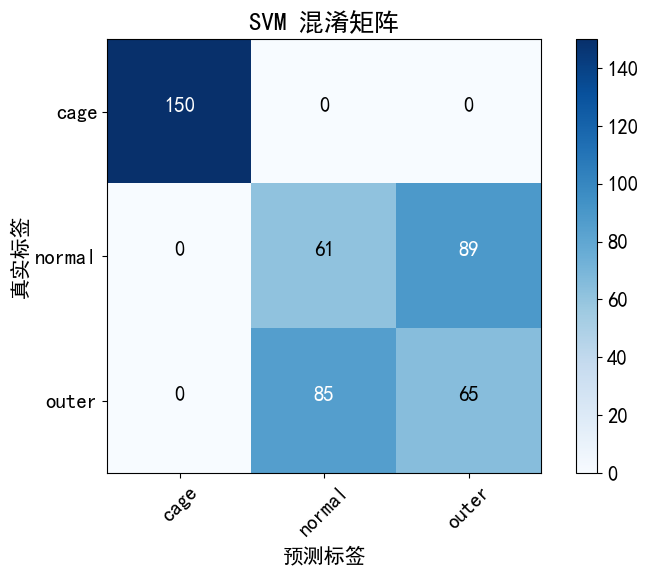

In [ ]:
X, y = load_data(data='orginal')
print(f"总样本数: {X.shape[0]}, 特征数: {X.shape[1]}, 类别数: {len(np.unique(y))}")
X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)
print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")
svm_model = train_svm(X_train, X_test, y_train, y_test)


使用的去噪数据
加载 cage_denoised 数据，原始形状: (20480, 150)
cage_denoised 处理后样本数: 750, 每个样本长度: 4096
加载 noramal_denoised 数据，原始形状: (20480, 150)
noramal_denoised 处理后样本数: 750, 每个样本长度: 4096
加载 outer_denoised 数据，原始形状: (20480, 150)
outer_denoised 处理后样本数: 750, 每个样本长度: 4096
总样本数: 2250, 特征数: 4096, 类别数: 3
训练集样本数: 1800, 测试集样本数: 450

SVM 模型评估:
准确率: 0.7267

混淆矩阵:
[[140   0  10]
 [  0  89  61]
 [  0  52  98]]

分类报告:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       150
           1       0.63      0.59      0.61       150
           2       0.58      0.65      0.61       150

    accuracy                           0.73       450
   macro avg       0.74      0.73      0.73       450
weighted avg       0.74      0.73      0.73       450



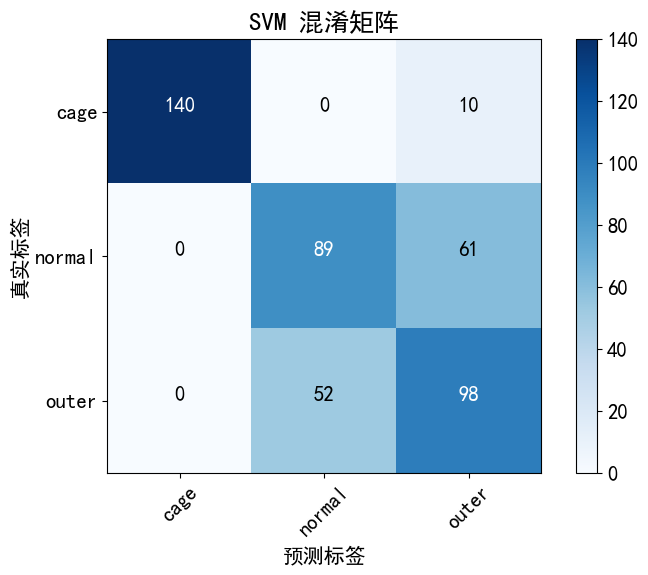

In [ ]:
X, y = load_data(data='denoised')
print(f"总样本数: {X.shape[0]}, 特征数: {X.shape[1]}, 类别数: {len(np.unique(y))}")
X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)
print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")
svm_model = train_svm(X_train, X_test, y_train, y_test)


使用的原始数据
加载 cage_original 数据，原始形状: (20480, 150)
cage_original 处理后样本数: 750, 每个样本长度: 4096
加载 noramal_original 数据，原始形状: (20480, 150)
noramal_original 处理后样本数: 750, 每个样本长度: 4096
加载 outer_original 数据，原始形状: (20480, 150)
outer_original 处理后样本数: 750, 每个样本长度: 4096
总样本数: 2250, 特征数: 4096, 类别数: 3
训练集样本数: 1800, 测试集样本数: 450

随机森林 模型评估:
准确率: 0.9044

混淆矩阵:
[[150   0   0]
 [  0 138  12]
 [  0  31 119]]

分类报告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       0.82      0.92      0.87       150
           2       0.91      0.79      0.85       150

    accuracy                           0.90       450
   macro avg       0.91      0.90      0.90       450
weighted avg       0.91      0.90      0.90       450



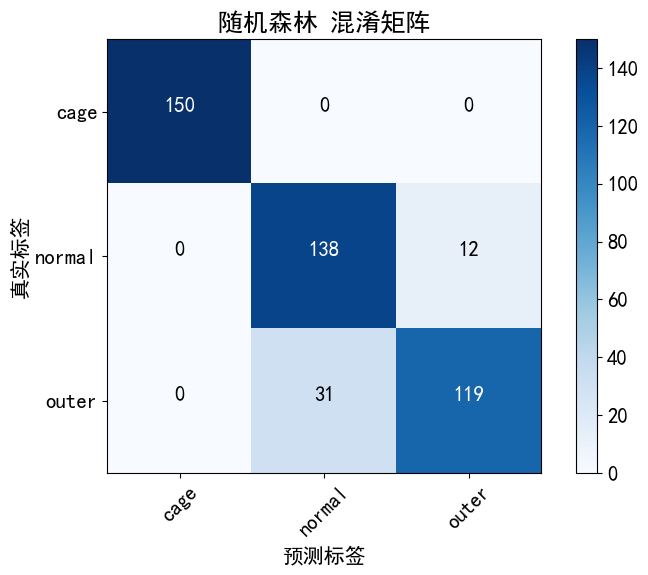

In [ ]:
X, y = load_data(data='orginal')
print(f"总样本数: {X.shape[0]}, 特征数: {X.shape[1]}, 类别数: {len(np.unique(y))}")
X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)
print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")
rf_model = train_random_forest(X_train, X_test, y_train, y_test)


使用的去噪数据
加载 cage_denoised 数据，原始形状: (20480, 150)
cage_denoised 处理后样本数: 750, 每个样本长度: 4096
加载 noramal_denoised 数据，原始形状: (20480, 150)
noramal_denoised 处理后样本数: 750, 每个样本长度: 4096
加载 outer_denoised 数据，原始形状: (20480, 150)
outer_denoised 处理后样本数: 750, 每个样本长度: 4096
总样本数: 2250, 特征数: 4096, 类别数: 3
训练集样本数: 1800, 测试集样本数: 450

随机森林 模型评估:
准确率: 0.9844

混淆矩阵:
[[144   6   0]
 [  0 150   0]
 [  0   1 149]]

分类报告:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       150
           1       0.96      1.00      0.98       150
           2       1.00      0.99      1.00       150

    accuracy                           0.98       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.99      0.98      0.98       450



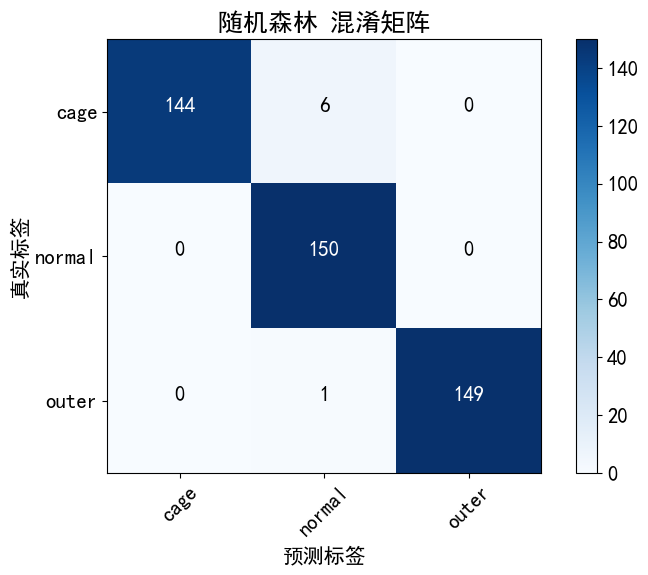

In [ ]:
X, y = load_data(data='denoised')
print(f"总样本数: {X.shape[0]}, 特征数: {X.shape[1]}, 类别数: {len(np.unique(y))}")
X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)
print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")
rf_model = train_random_forest(X_train, X_test, y_train, y_test)
